In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=YPy6GFmLiJMiz8zA_Z8yU-ouLuRAzTl7AjHfSTGwLCI&tc=7nwf-ttw_hdUgv6qKxytoVOGR7GokYWYOG_jnMCbIPE&cc=WptF12sUWQUWvRaBsHE-5DWlo2hxd56ELUKkyXDyr6s

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh56isAlTZyZGGbe85mKsSVVgXvJFGou_YVrcmG4JurNpa68BuZG59c

Successfully saved authorization token.


In [ ]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [ ]:
elv.gt(0.0)

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [ ]:
import folium

image_viz_params = {

    'min': 0,
    'max': 1,
    'palette': [
        'F2F2F2', '63C600'
    ],
}

map_l8 = folium.Map(location=[37.5010, -122.1899], zoom_start=10)
map_l8.add_ee_layer(elv.gt(1000.0),image_viz_params, 'false color composite')
display(map_l8)

In [ ]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [ ]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [ ]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 196 m
Average daytime LST at urban point: 22.11 °C
Land cover value at urban point is: 13


In [ ]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id',
  'longitude',
  'latitude',
  'time',
  'LST_Day_1km',
  'QC_Day',
  'Day_view_time',
  'Day_view_angle',
  'LST_Night_1km',
  'QC_Night',
  'Night_view_time',
  'Night_view_angle',
  'Emis_31',
  'Emis_32',
  'Clear_day_cov',
  'Clear_night_cov'],
 ['2000_02_24',
  4.810478346460038,
  45.77365530231022,
  951350400000,
  None,
  2,
  None,
  None,
  None,
  2,
  None,
  None,
  None,
  None,
  None,
  None],
 ['2000_02_25',
  4.810478346460038,
  45.77365530231022,
  951436800000,
  None,
  2,
  None,
  None,
  13596,
  81,
  224,
  84,
  240,
  243,
  None,
  1059],
 ['2000_02_26',
  4.810478346460038,
  45.77365530231022,
  951523200000,
  14365,
  145,
  120,
  115,
  13990,
  81,
  215,
  10,
  240,
  243,
  2000,
  4000],
 ['2000_02_27',
  4.810478346460038,
  45.77365530231022,
  951609600000,
  14391,
  81,
  110,
  38,
  14081,
  81,
  222,
  64,
  240,
  243,
  1967,
  2000]]

In [ ]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [ ]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
2,951523200000,2000-02-26,14.15
3,951609600000,2000-02-27,14.67
4,951696000000,2000-02-28,16.17
9,952128000000,2000-03-04,7.11
10,952214400000,2000-03-05,12.49


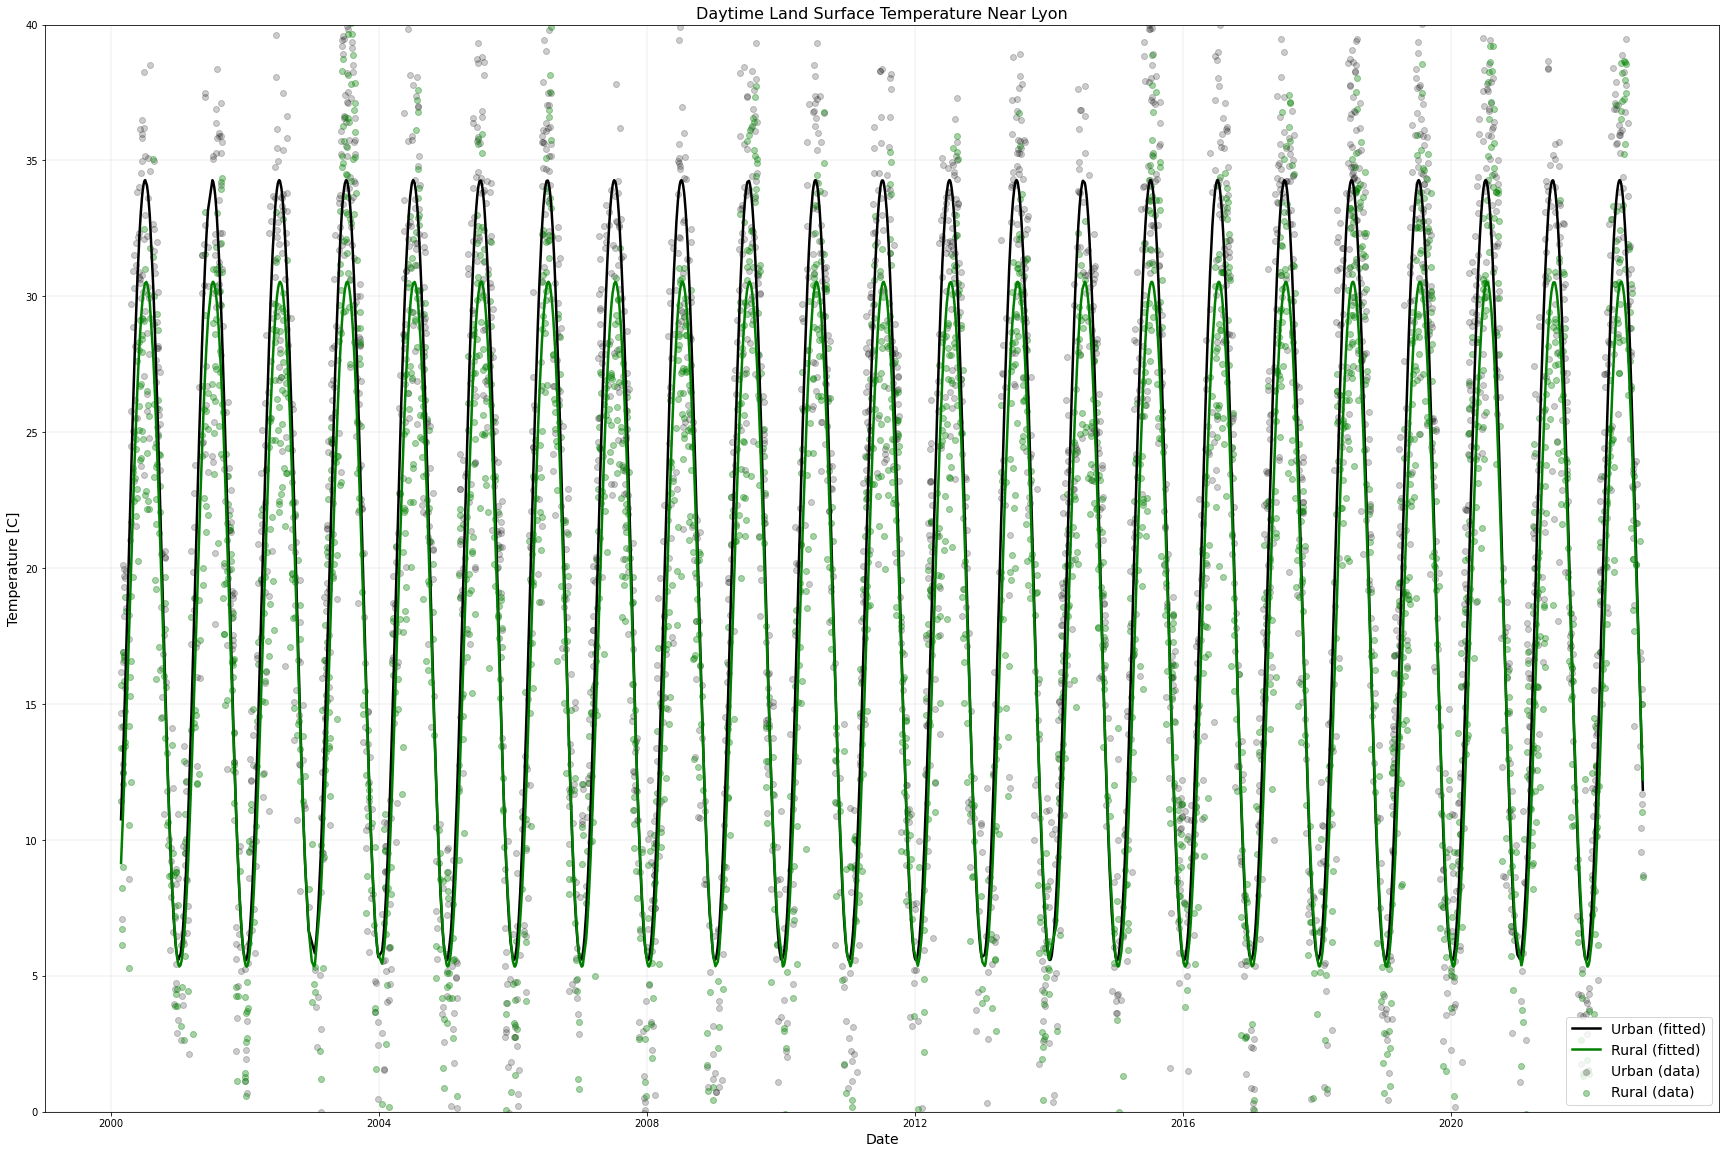

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(30, 20))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()